In [31]:
# SIGNATE Student Cup 2021春【予測部門】における解放として有力なkNNと、特長量エンジニアリングについて、以下の記事を参考に学んでいく。
# https://signate.jp/competitions/449/discussions/pseudo-labeling-lb06630

In [32]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

# ワーニングの出力をなくして表示をシンプルにするもの？
# warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', UserWarning)

# 今回の分類数。ジャンルの数。
N_CLASSES = 11

# ファイルのインポート
INPUT = Path("input")
df_train = pd.read_csv(INPUT / "train.csv")
df_test = pd.read_csv(INPUT / "test.csv")
print(df_test.describe())
df_sample_sub = pd.read_csv(INPUT / "sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv(INPUT / "genre_labels.csv")


# trainデータとtestデータをミックスしている。
# 特長量エンジニアリングを別々にやるのは面倒なので、ここで合体させて、学習時に分けるようにしていると思われる。賢い。
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

# 合体させたときにgenre=-100にしているので、それを起点にtrainデータとtestデータを分ける。
def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test


# parameters

# def lgb_metric(preds, data):  
#     pred_labels = preds.reshape(N_CLASSES, -1).argmax(axis=0)
#     score = f1_score(data.get_label(), pred_labels, average="macro")
#     return "macro_f1", score, True

# 以下、lightGBMの学習時のパラメータ定義
learning_rate = 0.01

lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    #"metric": "None",
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": 0,
    "seed": 42,
}

#k近傍法のグループ数?
knn_n_neighbors = 6


# parameters - knn feature weights
# 以下、kNNの学習時のパラメータ定義。regionはラベルエンコーディング、その他の量的変数は標準化、それ以外にnanの数も特徴量として使っている。
knn_features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans'
]

dict_feature_weights = {}

# regionの特長量重みを設定。
# 以下のように重みを決めていくことができるらしい。
# 重みですが、最初に大まかに当たりをつけ(regionは違うものが近傍データとして選ばれないくらい大きめ、popularityも他の特徴より大きめなど)、
# 交差検証での精度を見ながら細かい調整をしています。
for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    dict_feature_weights[col] = 1.0

# popularityは他の特徴よりも大きめに設定。
dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

# k近傍法の特徴量重みをnumpy配列に変換。
knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])
print(knn_feature_weights)

# train,testデータに対して特長量エンジニアリングを行うため、合体させる。
df_main = merge_train_test(df_train, df_test)

             index   popularity   duration_ms  acousticness  positiveness   
count  4046.000000  4046.000000  4.046000e+03   4045.000000   4032.000000  \
mean   6068.500000    41.158181  2.418486e+05      0.335216      0.467855   
std    1168.123923    16.107248  7.829733e+04      0.236284      0.220606   
min    4046.000000     0.000000  5.826000e+03      0.012727      0.014537   
25%    5057.250000    31.000000  2.019200e+05      0.145535      0.288579   
50%    6068.500000    42.000000  2.353070e+05      0.245121      0.446927   
75%    7079.750000    52.000000  2.724925e+05      0.494312      0.641742   
max    8091.000000    82.000000  1.105001e+06      0.985922      1.000000   

       danceability     loudness       energy     liveness  speechiness   
count   4035.000000  4046.000000  4045.000000  4040.000000  4035.000000  \
mean       0.499143    -7.636531     0.608755     0.268926     0.201776   
std        0.161413     3.989469     0.200665     0.157032     0.086553   
min   

In [33]:
# 動作検証用のおためし。
df = df_main.copy()
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)
df.head()

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_L,region_M,region_N,region_O,region_P,region_Q,region_R,region_S,region_T,region_unknown
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,False,False,False,False,False,False,False,False,False,False
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,False,False,False,False,False,False,False,False,False,False
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,False,False,False,False,False,False,False,False,False,False
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,False,False,False,False,False,False,False,False,False,False
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,False,False,False,False,False,False,False,False,False,True


In [34]:
best_f1_score = 0.0

for pseudo_labeling_threshold in [0.95, 0.925, 0.9, 0.875, 0.85, -np.inf]:
    #疑似ラベルを使って学習する際の閾値を設定。confidenceがこの閾値を超える場合に、そのラベルを使って学習する。
    df = df_main.copy()
    # feature engineering
    # genreのラベル番号からジャンル名に変換している。
    df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))
    # tempoの値を平均値に変換している。
    df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)
    # regionのone-hotエンコーディング、ついでにunknownの列名を変更している。
    df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

    df["num_nans"] = 0
    for col in [
        "acousticness",
        "positiveness",
        "danceability",
        "energy",
        "liveness",
        "speechiness",
        "instrumentalness",
    ]:
        df["num_nans"] += df[col].isna()

    class CountEncoder:
        def fit(self, series):
            # "series"ごとの出現回数をカウント
            self.counts = series.groupby(series).count()
            return self

        def transform(self, series):
            # "series"の各要素を、fit時に集計した出現回数に置換
            return series.map(self.counts).fillna(0)

        def fit_transform(self, series):
            # fitとtransformをまとめて実行
            return self.fit(series).transform(series)
    columns_count_enc = ["region"]
    for col in columns_count_enc:
        # regionの出現回数をカウントして、新しい列を作成している。
        df["countenc_" + col] = CountEncoder().fit_transform(df[col])
        # 欠損値をnanに変換している。locはnanの行を取得している。
        df.loc[df[col].isna().values, "countenc_" + col] = np.nan


    columns_label_enc = ["region"]
    for col in columns_count_enc:
        # regionのラベルエンコーディングを行っている。
        # ラベルエンコーディングとは、カテゴリ変数を数値に変換すること。
        df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
        df.loc[df[col].isna().values, "labelenc_" + col] = np.nan

    class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
        EX_TRANS_METHODS = ["deviation", "zscore"]

        def __init__(self, group_key, group_values, agg_methods):
            self.group_key = group_key
            self.group_values = group_values

            self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
            self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
            self.df_agg = None

        def fit(self, df_train, y=None):
            """

            """
            if not self.agg_methods:
                return
            dfs = []
            for agg_method in self.agg_methods:
                if callable(agg_method):
                    agg_method_name = agg_method.__name__
                else:
                    agg_method_name = agg_method
                # group by key
                df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
                df_agg.columns = self._get_column_names(agg_method_name)
                dfs.append(df_agg)
            self.df_agg = pd.concat(dfs, axis=1).reset_index()

        def transform(self, df_eval):
            """
            Transform evaluation data.
            """
            key = self.group_key
            if self.agg_methods:
                df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
            else:
                df_features = df_eval[[self.group_key]].copy()
            if self.ex_trans_methods:
                if "deviation" in self.ex_trans_methods:
                    # deviationとは、平均からの差分。X - X.mean()
                    df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
                if "zscore" in self.ex_trans_methods:
                    # z-scoreとは、平均を引いて標準偏差で割ること。つまりは標準化。
                    df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                    / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
            df_features.drop(self.group_key, axis=1, inplace=True)
            return df_features

        def _get_column_names(self, method):
            return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

        def fit_transform(self, df_train, y=None):
            self.fit(df_train, y=y)
            return self.transform(df_train)   

    # tempoを対数変換し特徴量に追加している。
    df["log_tempo"] = np.log(df["tempo"])
    # カテゴリ変数の特徴量を抽出している。group_keyはregion、group_valuesは特徴量、agg_methodsは標準化。
    gfe = GroupFeatureExtractor(
        "region", 
        ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
        ["zscore"]
    )
    # fit_transformで特徴量を抽出している。
    df = pd.concat([df, gfe.fit_transform(df)], axis=1)
    # 一旦今のdfの結果を可視化する。
    print("add zscore features")
    print(df.head())
    print(df.info())
    print(df.describe())

    # k近傍法の特徴量を抽出するクラスを作成。
    class KNNFeatureExtractor:
        def __init__(self, n_neighbors=5):
            self.knn = KNeighborsClassifier(n_neighbors + 1)

        def fit(self, X, y):
            self.knn.fit(X, y)
            self.y = y if isinstance(y, np.ndarray) else np.array(y)
            return self

        def transform(self, X, is_train_data):
            # kneighborsを使用して距離とindexを取得する。
            distances, indexes = self.knn.kneighbors(X)
            distances = distances[:, 1:] if is_train_data else distances[:, :-1]
            indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
            labels = self.y[indexes]
            score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
            df_knn = pd.DataFrame(
                [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
                columns=score_columns
            )
            df_knn["max_knn_scores"] = df_knn.max(1)
            for col in score_columns:
                df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
            for i, col1 in enumerate(score_columns):
                for j, col2 in enumerate(score_columns[i+1:], i+1):
                    if {i, j} & {8, 10}:
                        df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
            df_knn["sum_knn_scores"] = df_knn.sum(1)

            return df_knn


    # feature scaling

    df["log_tempo"] = np.log(df["tempo"])
    for col in [
        'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
    ]:
        df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]


    #　特徴量作成用にマージしたデータをtrainデータとtestデータに分ける。
    df_train, df_test = split_train_test(df)
    target = df_train["genre"]
    
    
    # train
    # N_SPLITSは交差検証の分割数、SEED_SKFは乱数のシード値。
    N_SPLITS = 15
    SEED_SKF = 42
    np.random.seed(42)

    # StratifiedKFoldでデータを分割する。
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
    # oofはout of foldの略。交差検証の結果を格納するための変数。
    oof = np.zeros((len(df_train), N_CLASSES))
    # 予測結果を格納するための変数。
    predictions = np.zeros((len(df_test), N_CLASSES))
    # 特徴量の重要度を格納するための変数。
    df_feature_importance = pd.DataFrame()

    # 量的変数の特徴量定義
    features_numerical = [
        'popularity', 'duration_ms', 'acousticness',
        'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
        'speechiness', 'instrumentalness', 'tempo',
        'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
        'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
        'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
        'region_S', 'region_T', 'region_unknown', 'countenc_region',
        'num_nans',
        'agg_zscore_popularity_grpby_region',
        'agg_zscore_duration_ms_grpby_region',
        'agg_zscore_acousticness_grpby_region',
        'agg_zscore_positiveness_grpby_region',
        'agg_zscore_danceability_grpby_region',
        'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
        'agg_zscore_liveness_grpby_region',
        'agg_zscore_speechiness_grpby_region',
        'agg_zscore_instrumentalness_grpby_region',
        'agg_zscore_log_tempo_grpby_region',
        'knn_score_class00', 'knn_score_class01',
        'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
        'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
        'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
        'max_knn_scores',
        'sub_max_knn_scores_knn_score_class00',
        'sub_max_knn_scores_knn_score_class01',
        'sub_max_knn_scores_knn_score_class02',
        'sub_max_knn_scores_knn_score_class03',
        'sub_max_knn_scores_knn_score_class04',
        'sub_max_knn_scores_knn_score_class05',
        'sub_max_knn_scores_knn_score_class06',
        'sub_max_knn_scores_knn_score_class07',
        'sub_max_knn_scores_knn_score_class08',
        'sub_max_knn_scores_knn_score_class09',
        'sub_max_knn_scores_knn_score_class10',
        'sub_knn_score_class00_knn_score_class08',
        'sub_knn_score_class00_knn_score_class10',
        'sub_knn_score_class01_knn_score_class08',
        'sub_knn_score_class01_knn_score_class10',
        'sub_knn_score_class02_knn_score_class08',
        'sub_knn_score_class02_knn_score_class10',
        'sub_knn_score_class03_knn_score_class08',
        'sub_knn_score_class03_knn_score_class10',
        'sub_knn_score_class04_knn_score_class08',
        'sub_knn_score_class04_knn_score_class10',
        'sub_knn_score_class05_knn_score_class08',
        'sub_knn_score_class05_knn_score_class10',
        'sub_knn_score_class06_knn_score_class08',
        'sub_knn_score_class06_knn_score_class10',
        'sub_knn_score_class07_knn_score_class08',
        'sub_knn_score_class07_knn_score_class10',
        'sub_knn_score_class08_knn_score_class09',
        'sub_knn_score_class08_knn_score_class10',
        'sub_knn_score_class09_knn_score_class10',
        'sum_knn_scores'
    ]
    # カテゴリカル変数の特徴量定義
    features_categorical = ["labelenc_region"]
    features = features_numerical + features_categorical

    # 交差検証の実行
    for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
        print(f"------------------------------ fold {fold_} ------------------------------")

        # train dataのindexとvalidation dataのindexを取得して、reset_indexでindexを振り直している。drop=trueは元のindexを削除するため。
        df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
        df_val = df_train.loc[indexes_val].reset_index(drop=True)
        target_trn = target.loc[indexes_trn].reset_index(drop=True)
        target_val = target.loc[indexes_val].reset_index(drop=True)

        # make knn features
        X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
        knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
        df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
        X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
        df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
        X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
        df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
        for col in df_test_knn_features.columns:
            df_test[col] = df_test_knn_features[col]

        lgb_train = lgb.Dataset(
            df_trn.loc[:, features],
            label=target_trn,
            feature_name=features,
            categorical_feature=features_categorical
        )
        lgb_valid = lgb.Dataset(
            df_val.loc[:, features],
            label=target_val,
            feature_name=features,
            categorical_feature=features_categorical
        )

        lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
        num_round = 999999999
        verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
        evaluation_results = {} # 学習時のスコアを保存する辞書
        model = lgb.train(
            lgb_params,
            lgb_train, 
            num_round, 
            valid_sets=[lgb_train, lgb_valid], 
            callbacks=[lgb.early_stopping(stopping_rounds=50, 
                                verbose=True), # early_stopping用コールバック関数            fobj=None,            
                        lgb.log_evaluation(verbose_eval),
                        lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
#feval=lgb_metric,
        )

        # cv
        prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
        oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

        # feature importance
        df_fold_importance = pd.DataFrame()
        df_fold_importance["feature"] = features
        df_fold_importance["importance"] = model.feature_importance()
        df_fold_importance["fold"] = fold_
        df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

        # prediction for test data
        predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
        print()

    
    score = f1_score(target, oof.argmax(1), average="macro")
    print("CV score (not reliable!)")
    print(f"  f1: {score:8.5f}")
    print()
    print(classification_report(target, oof.argmax(1)))
    
    
    df_test["prediction"] = predictions.argmax(1)
    df_test["confidence"] = predictions.max(1)
    df_test["genre"] = np.where(predictions.max(1) > pseudo_labeling_threshold, predictions.argmax(1), -100)
    df = merge_train_test(df_train, df_test)
    df_main["genre"] = df_main["index"].map(dict(df[["index", "genre"]].values))
    print((df_test["confidence"] > pseudo_labeling_threshold).sum(), f"rows were filled. (confidence>{pseudo_labeling_threshold})")
    print("filled test labels:", np.bincount(df_test[df_test["genre"]!=-100]["genre"]))
    print("\n")
    # 一番良いスコアの時の結果を保存する。
    if score > best_f1_score:
        best_f1_score = score
        best_df_test = df_test.copy()
        # 一番良いpseudo_labeling_thresholdを保存する
        best_pseudo_labeling_threshold = pseudo_labeling_threshold



add zscore features
   index  genre  popularity  duration_ms  acousticness  positiveness   
0      0     10          11       201094      0.112811      0.157247  \
1      1      8          69       308493      0.101333      0.346563   
2      2      3          43       197225      0.496420      0.265391   
3      3     10          45       301092      0.165667      0.245533   
4      4      3          57       277348      0.190720      0.777578   

   danceability  loudness    energy  liveness  ...   
0      0.187841 -1.884852  0.893918  0.363568  ...  \
1      0.554444 -5.546495  0.874409  0.193892  ...   
2      0.457642 -9.255670  0.439933  0.217146  ...   
3      0.356578 -5.088788  0.868704  0.377025  ...   
4      0.830479 -3.933896  0.650149  0.169323  ...   

   agg_zscore_duration_ms_grpby_region  agg_zscore_acousticness_grpby_region   
0                            -0.535165                             -1.014876  \
1                             0.915294                        

/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[722]	training's multi_logloss: 0.63719	valid_1's multi_logloss: 0.866821

------------------------------ fold 1 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[957]	training's multi_logloss: 0.592877	valid_1's multi_logloss: 0.779181

------------------------------ fold 2 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[696]	training's multi_logloss: 0.639719	valid_1's multi_logloss: 0.805379

------------------------------ fold 3 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[697]	training's multi_logloss: 0.652066	valid_1's multi_logloss: 0.745833

------------------------------ fold 4 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1178]	training's multi_logloss: 0.578284	valid_1's multi_logloss: 0.761729

------------------------------ fold 5 ------------------------------
Training until validation scores don't improve for 50 rounds


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Early stopping, best iteration is:
[548]	training's multi_logloss: 0.676812	valid_1's multi_logloss: 0.821049

------------------------------ fold 6 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[746]	training's multi_logloss: 0.648701	valid_1's multi_logloss: 0.694938

------------------------------ fold 7 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	training's multi_logloss: 0.690969	valid_1's multi_logloss: 0.859752

------------------------------ fold 8 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[984]	training's multi_logloss: 0.592679	valid_1's multi_logloss: 0.882381

------------------------------ fold 9 ------------------------------
Training until validation scores don't improve for 50 rounds


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Early stopping, best iteration is:
[1230]	training's multi_logloss: 0.556078	valid_1's multi_logloss: 0.859852

------------------------------ fold 10 ------------------------------
Training until validation scores don't improve for 50 rounds


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Early stopping, best iteration is:
[483]	training's multi_logloss: 0.697557	valid_1's multi_logloss: 0.800032

------------------------------ fold 11 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[767]	training's multi_logloss: 0.624151	valid_1's multi_logloss: 0.785461

------------------------------ fold 12 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[606]	training's multi_logloss: 0.651355	valid_1's multi_logloss: 0.871401

------------------------------ fold 13 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[588]	training's multi_logloss: 0.662695	valid_1's multi_logloss: 0.844214

------------------------------ fold 14 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[541]	training's multi_logloss: 0.6804	valid_1's multi_logloss: 0.805726

CV score (not reliable!)
  f1:  0.66191

              precision    recall  f1-score   support

           0       0.83      0.62      0.71        32
           1       0.58      0.41      0.48       205
           2       0.71      0.58      0.63       191
           3       0.81      0.76      0.78       362
           4       0.71      0.60      0.65        45
           5       0.62      0.51      0.56       126
           6       0.56      0.36      0.44        50
           7       0.65      0.62      0.64       334
           8       0.72      0.80      0.75      1305
           9       0.86      0.81      0.83        59
          10       0.78      0.81      0.80      1337

    accuracy                           0.74      4046
   macro avg       0.71      0.63      0.66      4046
weighted avg       0.73      0.

/tmp/ipykernel_785/3537412669.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)
/tmp/ipykernel_785/3537412669.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["confidence"] = predictions.max(1)
/tmp/ipykernel_785/3537412669.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

408 rows were filled. (confidence>0.95)
filled test labels: [  3   0   0  95   0   0   0   0   6  18 286]


add zscore features
   index  genre  popularity  duration_ms  acousticness  positiveness   
0      0     10          11       201094      0.112811      0.157247  \
1      1      8          69       308493      0.101333      0.346563   
2      2      3          43       197225      0.496420      0.265391   
3      3     10          45       301092      0.165667      0.245533   
4      4      3          57       277348      0.190720      0.777578   

   danceability  loudness    energy  liveness  ...   
0      0.187841 -1.884852  0.893918  0.363568  ...  \
1      0.554444 -5.546495  0.874409  0.193892  ...   
2      0.457642 -9.255670  0.439933  0.217146  ...   
3      0.356578 -5.088788  0.868704  0.377025  ...   
4      0.830479 -3.933896  0.650149  0.169323  ...   

   agg_zscore_duration_ms_grpby_region  agg_zscore_acousticness_grpby_region   
0                            -0.53

/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[982]	training's multi_logloss: 0.538058	valid_1's multi_logloss: 0.739858

------------------------------ fold 1 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1052]	training's multi_logloss: 0.533298	valid_1's multi_logloss: 0.610063

------------------------------ fold 2 ------------------------------
Training until validation scores don't improve for 50 rounds


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Early stopping, best iteration is:
[868]	training's multi_logloss: 0.549661	valid_1's multi_logloss: 0.741489

------------------------------ fold 3 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1448]	training's multi_logloss: 0.48351	valid_1's multi_logloss: 0.80483

------------------------------ fold 4 ------------------------------
Training until validation scores don't improve for 50 rounds


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Early stopping, best iteration is:
[916]	training's multi_logloss: 0.560245	valid_1's multi_logloss: 0.705422

------------------------------ fold 5 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[691]	training's multi_logloss: 0.586786	valid_1's multi_logloss: 0.779475

------------------------------ fold 6 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1053]	training's multi_logloss: 0.535096	valid_1's multi_logloss: 0.729237

------------------------------ fold 7 ------------------------------
Training until validation scores don't improve for 50 rounds


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Early stopping, best iteration is:
[870]	training's multi_logloss: 0.557826	valid_1's multi_logloss: 0.708394

------------------------------ fold 8 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[629]	training's multi_logloss: 0.594366	valid_1's multi_logloss: 0.765889

------------------------------ fold 9 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[903]	training's multi_logloss: 0.544982	valid_1's multi_logloss: 0.790375

------------------------------ fold 10 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[547]	training's multi_logloss: 0.613466	valid_1's multi_logloss: 0.822686

------------------------------ fold 11 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[672]	training's multi_logloss: 0.58618	valid_1's multi_logloss: 0.790767

------------------------------ fold 12 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[453]	training's multi_logloss: 0.626768	valid_1's multi_logloss: 0.768596

------------------------------ fold 13 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[534]	training's multi_logloss: 0.621291	valid_1's multi_logloss: 0.766786

------------------------------ fold 14 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[540]	training's multi_logloss: 0.613363	valid_1's multi_logloss: 0.734657

CV score (not reliable!)
  f1:  0.67777

              precision    recall  f1-score   support

           0       0.83      0.69      0.75        35
           1       0.58      0.41      0.48       205
           2       0.72      0.57      0.63       191
           3       0.85      0.81      0.83       457
           4       0.70      0.67      0.68        45
           5       0.64      0.50      0.56       126
           6       0.57      0.34      0.42        50
           7       0.63      0.60      0.62       334
           8       0.72      0.80      0.76      1311
           9       0.88      0.90      0.89        77
          10       0.81      0.84      0.83      1623

    accuracy                           0.76      4454
   macro avg       0.72      0.65      0.68      4454
weighted avg       0.75      

/tmp/ipykernel_785/3537412669.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)
/tmp/ipykernel_785/3537412669.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["confidence"] = predictions.max(1)
/tmp/ipykernel_785/3537412669.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

add zscore features
   index  genre  popularity  duration_ms  acousticness  positiveness   
0      0     10          11       201094      0.112811      0.157247  \
1      1      8          69       308493      0.101333      0.346563   
2      2      3          43       197225      0.496420      0.265391   
3      3     10          45       301092      0.165667      0.245533   
4      4      3          57       277348      0.190720      0.777578   

   danceability  loudness    energy  liveness  ...   
0      0.187841 -1.884852  0.893918  0.363568  ...  \
1      0.554444 -5.546495  0.874409  0.193892  ...   
2      0.457642 -9.255670  0.439933  0.217146  ...   
3      0.356578 -5.088788  0.868704  0.377025  ...   
4      0.830479 -3.933896  0.650149  0.169323  ...   

   agg_zscore_duration_ms_grpby_region  agg_zscore_acousticness_grpby_region   
0                            -0.535165                             -1.014876  \
1                             0.915294                        

/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1069]	training's multi_logloss: 0.474478	valid_1's multi_logloss: 0.659376

------------------------------ fold 1 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[710]	training's multi_logloss: 0.512833	valid_1's multi_logloss: 0.785048

------------------------------ fold 2 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[516]	training's multi_logloss: 0.557596	valid_1's multi_logloss: 0.748404

------------------------------ fold 3 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[715]	training's multi_logloss: 0.5168	valid_1's multi_logloss: 0.689904

------------------------------ fold 4 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1232]	training's multi_logloss: 0.465146	valid_1's multi_logloss: 0.626076

------------------------------ fold 5 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[717]	training's multi_logloss: 0.526735	valid_1's multi_logloss: 0.635172

------------------------------ fold 6 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[990]	training's multi_logloss: 0.490111	valid_1's multi_logloss: 0.729221

------------------------------ fold 7 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[714]	training's multi_logloss: 0.516419	valid_1's multi_logloss: 0.730134

------------------------------ fold 8 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[645]	training's multi_logloss: 0.538685	valid_1's multi_logloss: 0.67213

------------------------------ fold 9 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[818]	training's multi_logloss: 0.51092	valid_1's multi_logloss: 0.58541

------------------------------ fold 10 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[642]	training's multi_logloss: 0.545978	valid_1's multi_logloss: 0.638574

------------------------------ fold 11 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[407]	training's multi_logloss: 0.578611	valid_1's multi_logloss: 0.668901

------------------------------ fold 12 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[597]	training's multi_logloss: 0.540586	valid_1's multi_logloss: 0.728496

------------------------------ fold 13 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[738]	training's multi_logloss: 0.533802	valid_1's multi_logloss: 0.543301

------------------------------ fold 14 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[658]	training's multi_logloss: 0.536058	valid_1's multi_logloss: 0.631826

CV score (not reliable!)
  f1:  0.69077

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        44
           1       0.54      0.41      0.47       209
           2       0.73      0.58      0.64       198
           3       0.87      0.86      0.86       525
           4       0.69      0.63      0.66        46
           5       0.66      0.51      0.57       132
           6       0.57      0.34      0.42        50
           7       0.64      0.62      0.63       334
           8       0.74      0.81      0.77      1436
           9       0.92      0.91      0.92        93
          10       0.84      0.86      0.85      1871

    accuracy                           0.78      4938
   macro avg       0.73      0.66      0.69      4938
weighted avg       0.78      

/tmp/ipykernel_785/3537412669.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)
/tmp/ipykernel_785/3537412669.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["confidence"] = predictions.max(1)
/tmp/ipykernel_785/3537412669.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

427 rows were filled. (confidence>0.9)
filled test labels: [  3   3  17  48   1  12   1   4 209   3 126]


add zscore features
   index  genre  popularity  duration_ms  acousticness  positiveness   
0      0     10          11       201094      0.112811      0.157247  \
1      1      8          69       308493      0.101333      0.346563   
2      2      3          43       197225      0.496420      0.265391   
3      3     10          45       301092      0.165667      0.245533   
4      4      3          57       277348      0.190720      0.777578   

   danceability  loudness    energy  liveness  ...   
0      0.187841 -1.884852  0.893918  0.363568  ...  \
1      0.554444 -5.546495  0.874409  0.193892  ...   
2      0.457642 -9.255670  0.439933  0.217146  ...   
3      0.356578 -5.088788  0.868704  0.377025  ...   
4      0.830479 -3.933896  0.650149  0.169323  ...   

   agg_zscore_duration_ms_grpby_region  agg_zscore_acousticness_grpby_region   
0                            -0.535

/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[880]	training's multi_logloss: 0.465805	valid_1's multi_logloss: 0.617402

------------------------------ fold 1 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[582]	training's multi_logloss: 0.501026	valid_1's multi_logloss: 0.649461

------------------------------ fold 2 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[677]	training's multi_logloss: 0.486241	valid_1's multi_logloss: 0.593243

------------------------------ fold 3 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1207]	training's multi_logloss: 0.424501	valid_1's multi_logloss: 0.568746

------------------------------ fold 4 ------------------------------
Training until validation scores don't improve for 50 rounds


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Early stopping, best iteration is:
[1684]	training's multi_logloss: 0.389384	valid_1's multi_logloss: 0.58068

------------------------------ fold 5 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[555]	training's multi_logloss: 0.516543	valid_1's multi_logloss: 0.611245

------------------------------ fold 6 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[882]	training's multi_logloss: 0.465839	valid_1's multi_logloss: 0.615553

------------------------------ fold 7 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[442]	training's multi_logloss: 0.519906	valid_1's multi_logloss: 0.720308

------------------------------ fold 8 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[590]	training's multi_logloss: 0.508963	valid_1's multi_logloss: 0.615253

------------------------------ fold 9 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[722]	training's multi_logloss: 0.477839	valid_1's multi_logloss: 0.642611

------------------------------ fold 10 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[780]	training's multi_logloss: 0.480259	valid_1's multi_logloss: 0.667954

------------------------------ fold 11 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[597]	training's multi_logloss: 0.500983	valid_1's multi_logloss: 0.631991

------------------------------ fold 12 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[483]	training's multi_logloss: 0.521426	valid_1's multi_logloss: 0.60842

------------------------------ fold 13 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1049]	training's multi_logloss: 0.445559	valid_1's multi_logloss: 0.614942

------------------------------ fold 14 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1320]	training's multi_logloss: 0.423987	valid_1's multi_logloss: 0.537566

CV score (not reliable!)
  f1:  0.70691

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        47
           1       0.56      0.42      0.48       212
           2       0.74      0.61      0.67       215
           3       0.88      0.84      0.86       573
           4       0.74      0.55      0.63        47
           5       0.67      0.58      0.62       144
           6       0.70      0.37      0.49        51
           7       0.63      0.61      0.62       338
           8       0.78      0.84      0.81      1645
           9       0.90      0.92      0.91        96
          10       0.85      0.87      0.86      1997

    accuracy                           0.80      5365
   macro avg       0.76      0.67      0.71      5365
weighted avg       0.80     

/tmp/ipykernel_785/3537412669.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)
/tmp/ipykernel_785/3537412669.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["confidence"] = predictions.max(1)
/tmp/ipykernel_785/3537412669.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1261]	training's multi_logloss: 0.400984	valid_1's multi_logloss: 0.570025

------------------------------ fold 1 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[553]	training's multi_logloss: 0.476132	valid_1's multi_logloss: 0.619838

------------------------------ fold 2 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[567]	training's multi_logloss: 0.478122	valid_1's multi_logloss: 0.603318

------------------------------ fold 3 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[626]	training's multi_logloss: 0.472611	valid_1's multi_logloss: 0.577915

------------------------------ fold 4 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[795]	training's multi_logloss: 0.447738	valid_1's multi_logloss: 0.590646

------------------------------ fold 5 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[997]	training's multi_logloss: 0.422567	valid_1's multi_logloss: 0.651556

------------------------------ fold 6 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[485]	training's multi_logloss: 0.500033	valid_1's multi_logloss: 0.61259

------------------------------ fold 7 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	training's multi_logloss: 0.471156	valid_1's multi_logloss: 0.580981

------------------------------ fold 8 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[738]	training's multi_logloss: 0.451165	valid_1's multi_logloss: 0.594768

------------------------------ fold 9 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[953]	training's multi_logloss: 0.426832	valid_1's multi_logloss: 0.609275

------------------------------ fold 10 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[854]	training's multi_logloss: 0.448099	valid_1's multi_logloss: 0.572986

------------------------------ fold 11 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1156]	training's multi_logloss: 0.414002	valid_1's multi_logloss: 0.510981

------------------------------ fold 12 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1574]	training's multi_logloss: 0.37015	valid_1's multi_logloss: 0.516875

------------------------------ fold 13 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[606]	training's multi_logloss: 0.472955	valid_1's multi_logloss: 0.618533

------------------------------ fold 14 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[923]	training's multi_logloss: 0.440014	valid_1's multi_logloss: 0.511284

CV score (not reliable!)
  f1:  0.72111

              precision    recall  f1-score   support

           0       0.89      0.78      0.83        50
           1       0.57      0.45      0.51       217
           2       0.76      0.60      0.67       222
           3       0.90      0.87      0.88       604
           4       0.76      0.65      0.70        52
           5       0.67      0.63      0.65       150
           6       0.63      0.33      0.44        51
           7       0.66      0.62      0.64       355
           8       0.80      0.86      0.83      1828
           9       0.92      0.93      0.92        98
          10       0.86      0.88      0.87      2076

    accuracy                           0.81      5703
   macro avg       0.76      0.69      0.72      5703
weighted avg       0.81      

/tmp/ipykernel_785/3537412669.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)
/tmp/ipykernel_785/3537412669.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["confidence"] = predictions.max(1)
/tmp/ipykernel_785/3537412669.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

243 rows were filled. (confidence>0.85)
filled test labels: [  1   3   5  17   3   7   2  24 118   1  62]


add zscore features
   index  genre  popularity  duration_ms  acousticness  positiveness   
0      0     10          11       201094      0.112811      0.157247  \
1      1      8          69       308493      0.101333      0.346563   
2      2      3          43       197225      0.496420      0.265391   
3      3     10          45       301092      0.165667      0.245533   
4      4      3          57       277348      0.190720      0.777578   

   danceability  loudness    energy  liveness  ...   
0      0.187841 -1.884852  0.893918  0.363568  ...  \
1      0.554444 -5.546495  0.874409  0.193892  ...   
2      0.457642 -9.255670  0.439933  0.217146  ...   
3      0.356578 -5.088788  0.868704  0.377025  ...   
4      0.830479 -3.933896  0.650149  0.169323  ...   

   agg_zscore_duration_ms_grpby_region  agg_zscore_acousticness_grpby_region   
0                            -0.53

/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[649]	training's multi_logloss: 0.45466	valid_1's multi_logloss: 0.506771

------------------------------ fold 1 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[826]	training's multi_logloss: 0.428373	valid_1's multi_logloss: 0.54592

------------------------------ fold 2 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[667]	training's multi_logloss: 0.449559	valid_1's multi_logloss: 0.554652

------------------------------ fold 3 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[835]	training's multi_logloss: 0.431143	valid_1's multi_logloss: 0.520943

------------------------------ fold 4 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[614]	training's multi_logloss: 0.46121	valid_1's multi_logloss: 0.623612

------------------------------ fold 5 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	training's multi_logloss: 0.430701	valid_1's multi_logloss: 0.651382

------------------------------ fold 6 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1268]	training's multi_logloss: 0.386897	valid_1's multi_logloss: 0.628769

------------------------------ fold 7 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[651]	training's multi_logloss: 0.448522	valid_1's multi_logloss: 0.578495

------------------------------ fold 8 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[653]	training's multi_logloss: 0.457452	valid_1's multi_logloss: 0.545471

------------------------------ fold 9 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[586]	training's multi_logloss: 0.46551	valid_1's multi_logloss: 0.572522

------------------------------ fold 10 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[685]	training's multi_logloss: 0.448557	valid_1's multi_logloss: 0.57489

------------------------------ fold 11 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[594]	training's multi_logloss: 0.45405	valid_1's multi_logloss: 0.622955

------------------------------ fold 12 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[889]	training's multi_logloss: 0.423359	valid_1's multi_logloss: 0.497707

------------------------------ fold 13 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[749]	training's multi_logloss: 0.441582	valid_1's multi_logloss: 0.611707

------------------------------ fold 14 ------------------------------


/tmp/ipykernel_785/3537412669.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[640]	training's multi_logloss: 0.461237	valid_1's multi_logloss: 0.528794

CV score (not reliable!)
  f1:  0.72332

              precision    recall  f1-score   support

           0       0.85      0.78      0.82        51
           1       0.59      0.46      0.52       220
           2       0.76      0.61      0.67       227
           3       0.89      0.87      0.88       621
           4       0.71      0.64      0.67        55
           5       0.67      0.62      0.64       157
           6       0.58      0.40      0.47        53
           7       0.68      0.64      0.66       379
           8       0.82      0.86      0.84      1946
           9       0.89      0.92      0.91        99
          10       0.86      0.88      0.87      2138

    accuracy                           0.82      5946
   macro avg       0.76      0.70      0.72      5946
weighted avg       0.82      

/tmp/ipykernel_785/3537412669.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)
/tmp/ipykernel_785/3537412669.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["confidence"] = predictions.max(1)
/tmp/ipykernel_785/3537412669.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

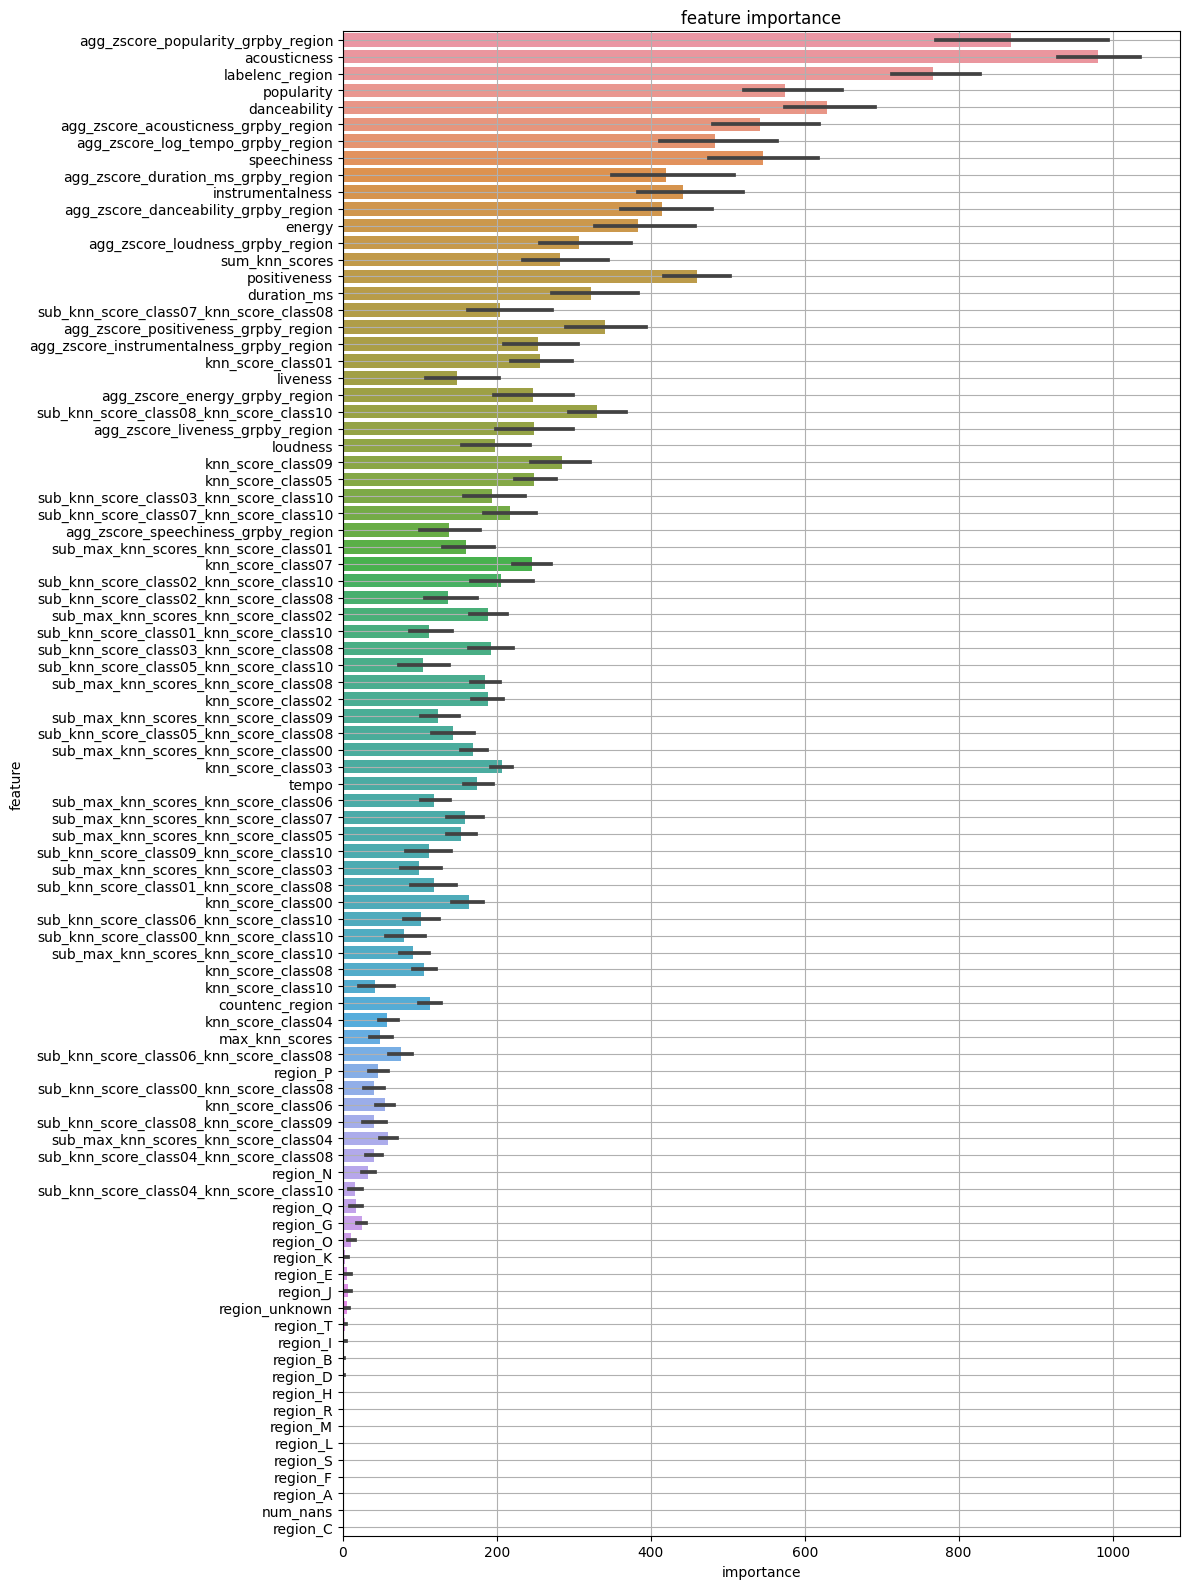

In [35]:
plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

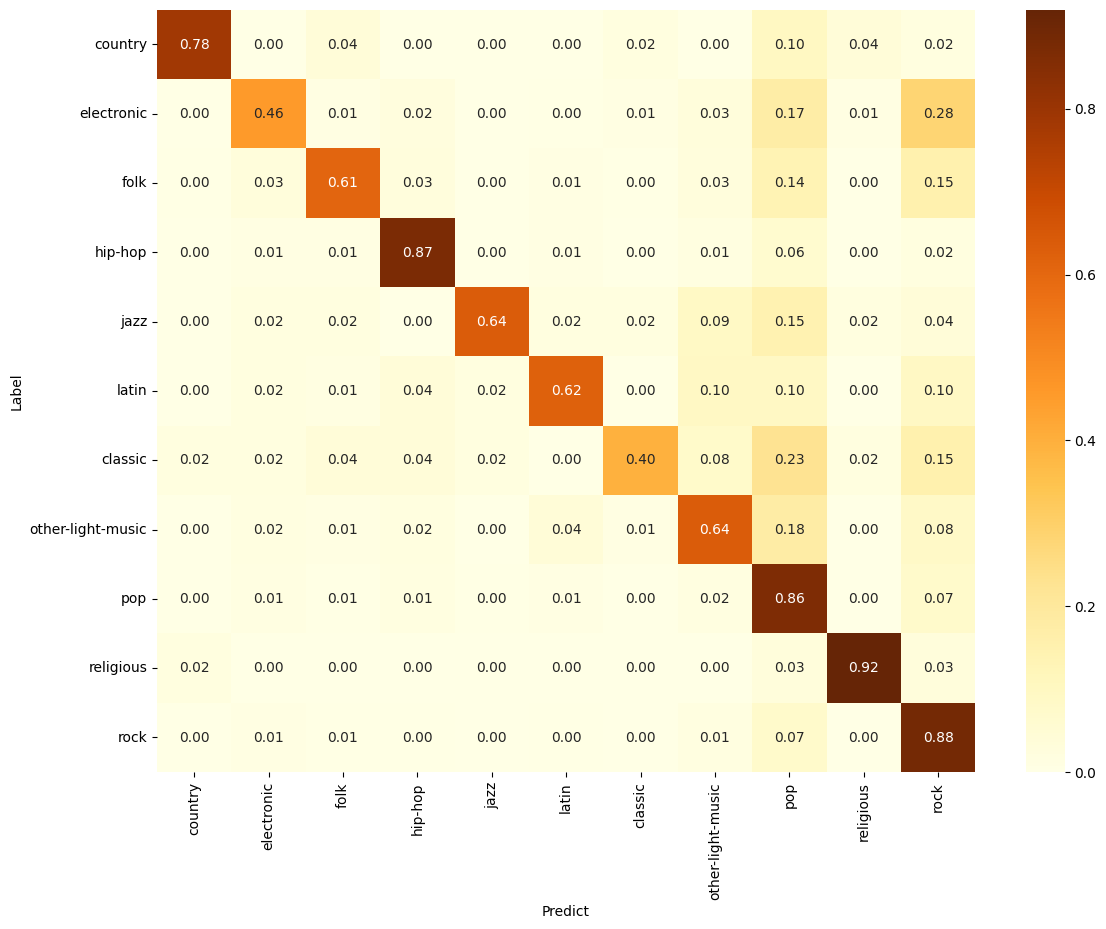

In [36]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()

In [37]:
# df_submission = df_sample_sub.copy()
# df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
# assert not df_submission["genre"].isna().any()
# display(df_submission.head(10))

# # make submission file
# df_submission.to_csv("submission.csv", header=None, index=False)

AssertionError: 